# Objective
* 20181225: 
    * Predict stock price in next day using XGBoost
    * Given prices and other features for the last N days, we do prediction for day N+1
    * Here we split 3 years of data into train(60%), dev(20%) and test(20%)
* 20190110 - Diff from StockPricePrediction_v1_xgboost.ipynb:
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 7                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Load data

In [2]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_17356\1660431608.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,month
0,2015-11-25,107.510002,107.660004,107.250000,107.470001,101.497200,1820300,11
1,2015-11-27,107.589996,107.760002,107.220001,107.629997,101.648300,552400,11
2,2015-11-30,107.779999,107.849998,107.110001,107.169998,101.213867,3618100,11
3,2015-12-01,107.589996,108.209999,107.370003,108.180000,102.167740,2443600,12
4,2015-12-02,108.099998,108.269997,106.879997,107.050003,101.100533,2937200,12


Text(0, 0.5, 'USD')

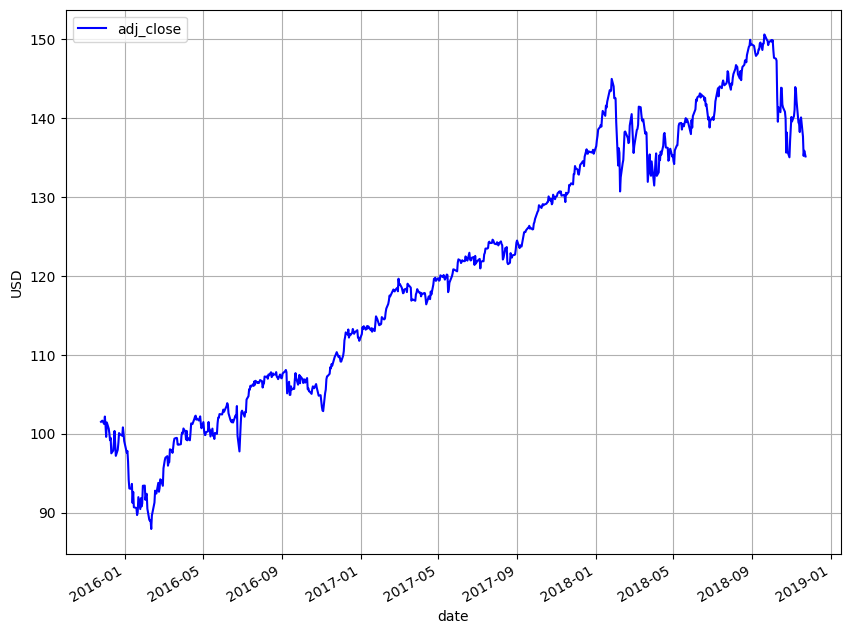

In [3]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Split into train, dev and test set

In [4]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 453
num_cv = 151
num_test = 151
train.shape = (453, 8)
cv.shape = (151, 8)
train_cv.shape = (604, 8)
test.shape = (151, 8)


# Scale the train, dev and test set and combine them to do feature engineering

In [5]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['open', 'high', 'low', 'close', 'adj_close', 'volume']])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
train_scaled[['date', 'month']] = train[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [1.13179757e+02 1.13586225e+02 1.12691545e+02 1.13190088e+02
 1.09092171e+02 2.59281148e+06]
scaler.var_ = [8.18020920e+01 7.97106998e+01 8.39537740e+01 8.15594150e+01
 9.51990222e+01 1.88602129e+12]
train_scaled.shape = (453, 6)
train_scaled.shape = (453, 8)


,open,high,low,close,adj_close,volume,date,month
0,-0.626877,-0.663773,-0.593885,-0.633382,-0.778413,-0.562512,2015-11-25,11
1,-0.618032,-0.652573,-0.597159,-0.615666,-0.762926,-1.485746,2015-11-27,11
2,-0.597024,-0.642492,-0.609164,-0.666601,-0.807452,0.746574,2015-11-30,11
3,-0.618032,-0.602170,-0.580788,-0.554764,-0.709689,-0.108650,2015-12-01,12
4,-0.561644,-0.595450,-0.634266,-0.679888,-0.819067,0.250770,2015-12-02,12


In [6]:
# Do scaling for dev set
cv_scaled  = scaler.transform(cv[['open', 'high', 'low', 'close', 'adj_close', 'volume']])

# Convert the numpy array back into pandas dataframe
cv_scaled = pd.DataFrame(cv_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
cv_scaled[['date', 'month']] = cv.reset_index()[['date', 'month']]
print("cv_scaled.shape = " + str(cv_scaled.shape))
cv_scaled.head()

cv_scaled.shape = (151, 8)


,open,high,low,close,adj_close,volume,date,month
0,1.664030,1.668193,1.678390,1.679755,1.685439,-0.800693,2017-09-14,9
1,1.672876,1.683874,1.692577,1.706331,1.709497,-0.772950,2017-09-15,9
2,1.732582,1.737638,1.746055,1.740657,1.740569,-0.582900,2017-09-18,9
3,1.755799,1.737638,1.763518,1.747300,1.746584,-0.983825,2017-09-19,9
4,1.760223,1.749959,1.736233,1.770553,1.767632,-0.628847,2017-09-20,9


In [7]:
# Do scaling for test set
test_scaled  = scaler.transform(test[['open', 'high', 'low', 'close', 'adj_close', 'volume']])

# Convert the numpy array back into pandas dataframe
test_scaled = pd.DataFrame(test_scaled, columns=['open', 'high', 'low', 'close', 'adj_close', 'volume'])
test_scaled[['date', 'month']] = test.reset_index()[['date', 'month']]
print("test_scaled.shape = " + str(test_scaled.shape))
test_scaled.head()

test_scaled.shape = (151, 8)


,open,high,low,close,adj_close,volume,date,month
0,2.719927,2.752413,2.632263,2.686285,2.780305,-0.407123,2018-04-23,4
1,2.755308,2.755773,2.419443,2.503582,2.612709,0.335455,2018-04-24,4
2,2.497691,2.538481,2.392158,2.520191,2.627946,-0.231126,2018-04-25,4
3,2.580615,2.698649,2.571146,2.663033,2.758975,-0.952587,2018-04-26,4
4,2.693390,2.705371,2.631172,2.672998,2.768116,-1.062539,2018-04-27,4


In [8]:
# Combine back train_scaled, cv_scaled, test_scaled together
df_scaled = pd.concat([train_scaled, cv_scaled, test_scaled], axis=0)
df_scaled.head()

,open,high,low,close,adj_close,volume,date,month
0,-0.626877,-0.663773,-0.593885,-0.633382,-0.778413,-0.562512,2015-11-25,11
1,-0.618032,-0.652573,-0.597159,-0.615666,-0.762926,-1.485746,2015-11-27,11
2,-0.597024,-0.642492,-0.609164,-0.666601,-0.807452,0.746574,2015-11-30,11
3,-0.618032,-0.602170,-0.580788,-0.554764,-0.709689,-0.108650,2015-12-01,12
4,-0.561644,-0.595450,-0.634266,-0.679888,-0.819067,0.250770,2015-12-02,12


# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [9]:
# Get difference between high and low of each day
df_scaled['range_hl'] = df_scaled['high'] - df_scaled['low']
df_scaled.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df_scaled['range_oc'] = df_scaled['open'] - df_scaled['close']
df_scaled.drop(['open', 'close'], axis=1, inplace=True)

df_scaled.head()

,adj_close,volume,date,month,range_hl,range_oc
0,-0.778413,-0.562512,2015-11-25,11,-0.069888,0.006505
1,-0.762926,-1.485746,2015-11-27,11,-0.055414,-0.002367
2,-0.807452,0.746574,2015-11-30,11,-0.033328,0.069577
3,-0.709689,-0.108650,2015-12-01,12,-0.021382,-0.063268
4,-0.819067,0.250770,2015-12-02,12,0.038816,0.118244


Now we use lags up to N number of days to use as features.

In [10]:
# Add a column 'order_day' to indicate the order of the rows by date
df_scaled['order_day'] = [x for x in list(range(len(df_scaled)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [11]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df_scaled[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df_scaled, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df_scaled = pd.merge(df_scaled, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df_scaled = df_scaled[N:]
    
df_scaled.head()

C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_17356\1059656672.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/7 [00:00<?, ?it/s]

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_5,volume_lag_5,adj_close_lag_6,range_hl_lag_6,range_oc_lag_6,volume_lag_6,adj_close_lag_7,range_hl_lag_7,range_oc_lag_7,volume_lag_7
7,-0.867462,0.296862,2015-12-07,12,0.016304,0.077418,7,-0.786156,0.094567,-0.172597,...,0.069577,0.746574,-0.762926,-0.055414,-0.002367,-1.485746,-0.778413,-0.069888,0.006505,-0.562512
8,-0.929412,0.405431,2015-12-08,12,0.005079,0.005656,8,-0.867462,0.016304,0.077418,...,-0.063268,-0.108650,-0.807452,-0.033328,0.069577,0.746574,-0.762926,-0.055414,-0.002367,-1.485746
9,-1.017496,1.155581,2015-12-09,12,0.130500,0.063300,9,-0.929412,0.005079,0.005656,...,0.118244,0.250770,-0.709689,-0.021382,-0.063268,-0.108650,-0.807452,-0.033328,0.069577,0.746574
10,-0.987490,0.795215,2015-12-10,12,0.005195,-0.011936,10,-1.017496,0.130500,0.063300,...,0.205855,0.548150,-0.819067,0.038816,0.118244,0.250770,-0.709689,-0.021382,-0.063268,-0.108650
11,-1.187854,1.826144,2015-12-11,12,0.024533,0.105603,11,-0.987490,0.005195,-0.011936,...,-0.172597,1.403301,-0.973937,0.148965,0.205855,0.548150,-0.819067,0.038816,0.118244,0.250770


In [12]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 748 entries, 7 to 754
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   adj_close        748 non-null    float64       
 1   volume           748 non-null    float64       
 2   date             748 non-null    datetime64[ns]
 3   month            748 non-null    int64         
 4   range_hl         748 non-null    float64       
 5   range_oc         748 non-null    float64       
 6   order_day        748 non-null    int64         
 7   adj_close_lag_1  748 non-null    float64       
 8   range_hl_lag_1   748 non-null    float64       
 9   range_oc_lag_1   748 non-null    float64       
 10  volume_lag_1     748 non-null    float64       
 11  adj_close_lag_2  748 non-null    float64       
 12  range_hl_lag_2   748 non-null    float64       
 13  range_oc_lag_2   748 non-null    float64       
 14  volume_lag_2     748 non-null    float64  

In [13]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [14]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Split the scaled features back into train, dev and test set

In [15]:
features = [
"adj_close_lag_1",
"range_hl_lag_1",
"range_oc_lag_1",
"volume_lag_1",
"adj_close_lag_2",
"range_hl_lag_2",
"range_oc_lag_2",
"volume_lag_2",
"adj_close_lag_3",
"range_hl_lag_3",
"range_oc_lag_3",
"volume_lag_3",
"adj_close_lag_4",
"range_hl_lag_4",
"range_oc_lag_4",
"volume_lag_4",
"adj_close_lag_5",
"range_hl_lag_5",
"range_oc_lag_5",
"volume_lag_5",
"adj_close_lag_6",
"range_hl_lag_6",
"range_oc_lag_6",
"volume_lag_6",
"adj_close_lag_7",
"range_hl_lag_7",
"range_oc_lag_7",
"volume_lag_7"
]

target = "adj_close"

# Split into train, cv, and test
train = df_scaled[:num_train]
cv = df_scaled[num_train:num_train+num_cv]
train_cv = df_scaled[:num_train+num_cv]
test = df_scaled[num_train+num_cv:]

# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (453, 28)
y_train.shape = (453,)
X_cv.shape = (151, 28)
y_cv.shape = (151,)
X_train_cv.shape = (604, 28)
y_train_cv.shape = (604,)
X_sample.shape = (144, 28)
y_sample.shape = (144,)


# EDA

Text(0, 0.5, 'USD (scaled)')

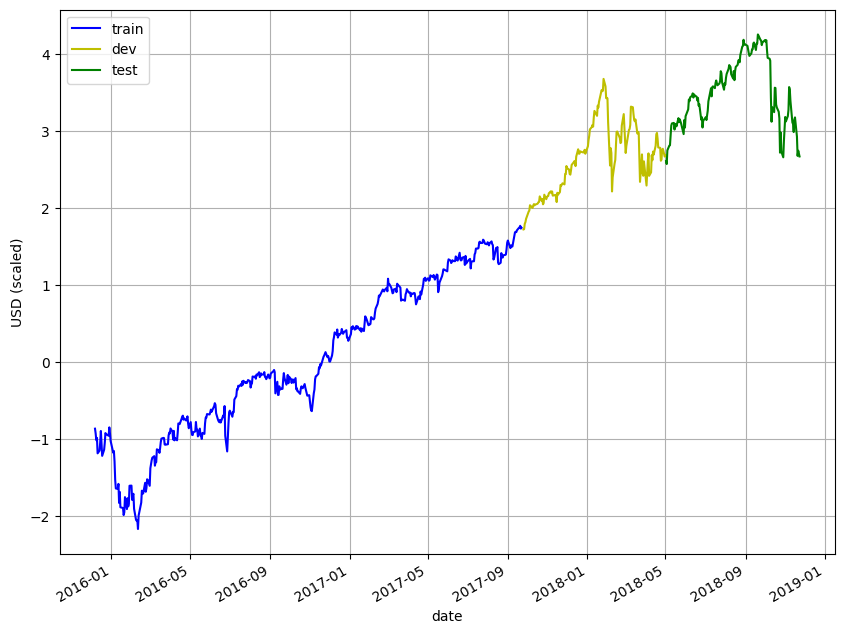

In [16]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")

# Train the model using XGBoost

In [17]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Predict on train set

In [18]:
# Do prediction on train set
est = model.predict(X_train)

# Calculate RMSE
math.sqrt(mean_squared_error(y_train, est))

0.03854108207666671

Text(0, 0.5, 'USD (scaled)')

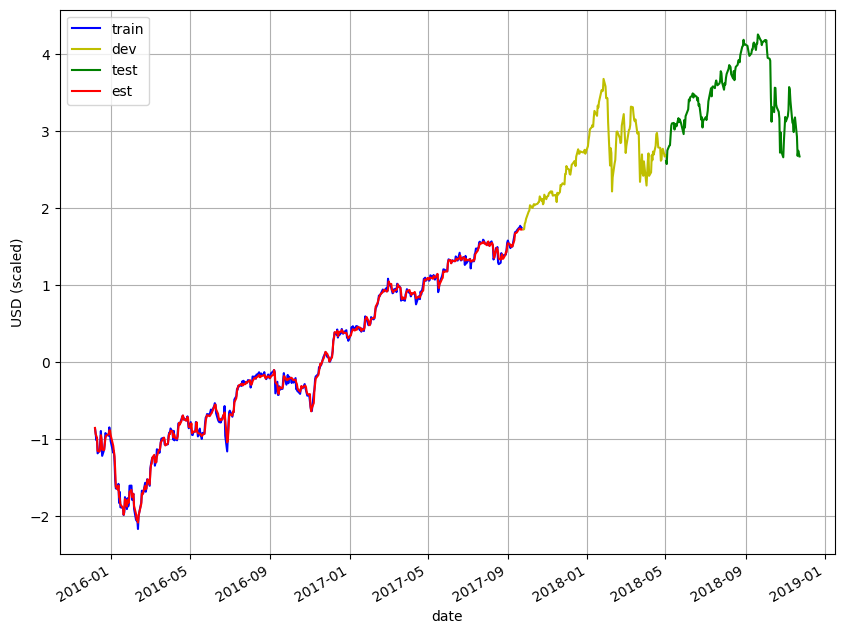

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")

# Predict on dev set

In [20]:
# Do prediction on test set
est = model.predict(X_cv)

# Calculate RMSE
math.sqrt(mean_squared_error(y_cv, est))

1.0374960761589989

Text(0, 0.5, 'USD (scaled)')

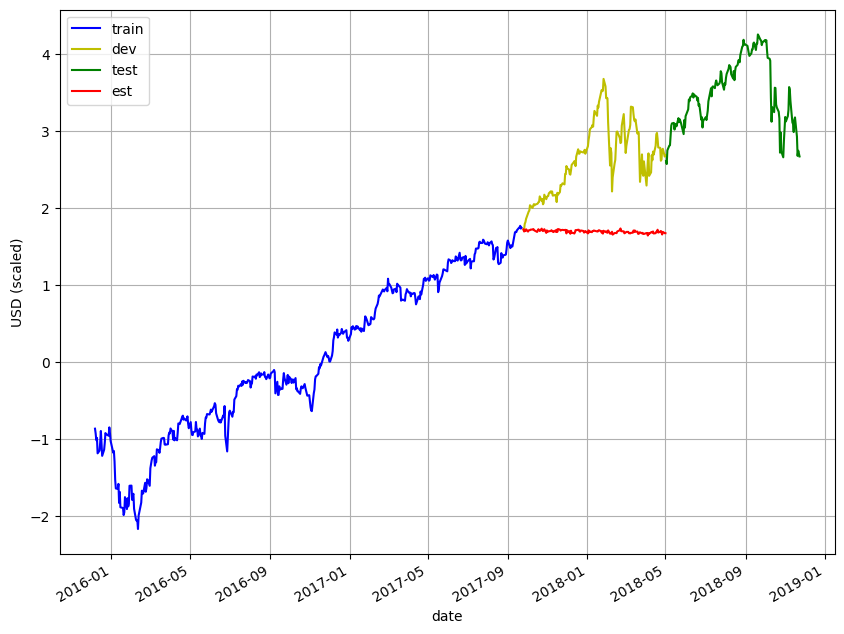

In [21]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")

# Findings
* Doesn't work well
* Likely because the model was trained on prices below ~1.7 and so when it saw prices above 1.7 for the dev set, it could not generalize well